## <font style="color:lightblue">Header</font>

### <font style="color:lightblue">Imports</font>

In [ ]:
#%load_ext autoreload
#%autoreload 2

import math
import numpy as np
import torch
import torch.nn as nn
from torchinfo import summary
import itertools
import random
import torchvision

import shiftpatch_module as sg




### <font style="color:lightblue">Redefine</font>

In [ ]:
sg.plt.rcParams['figure.dpi']=223





### <font style="color:lightblue">Configs</font>

In [ ]:
sg.set_seed(7)

sg.TCfg = sg.TCfgClass(
     exec = 1
    ,nofEpochs = None
    ,latentDim = 64
    ,batchSize = 2**9
    ,batchSplit = 1
    ,loaderWorkers = 16
    ,labelSmoothFac = 0.1 # For Fake labels (or set to 0.0 for no smoothing).
    ,learningRateD = 4e-5
    ,learningRateG = 4e-5
)

sg.DCfg = sg.DCfgClass()


### <font style="color:lightblue">Raw Read</font>

In [4]:
sg.samplingMask = sg.SamplingMask()
sg.samplingVari = sg.SamplingVariations()
sg.trainSet = sg.createTrainSet()
sg.testSet = sg.createTestSet()
sg.testLoader = sg.createDataLoader(sg.createSubSet(sg.testSet),
                                    num_workers=sg.TCfg.loaderWorkers)
sg.refImages, sg.refNoises = sg.createReferences(0)

### <font style="color:lightblue">Show</font>

(0, 3, 8, 1295)


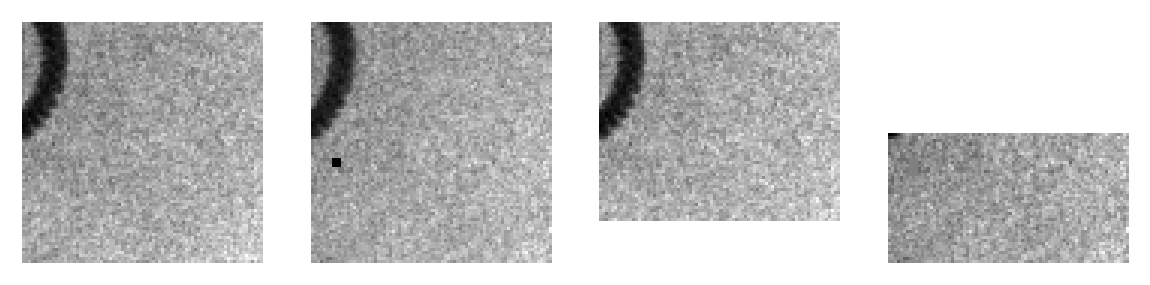

In [5]:

sg.showMe(sg.testSet)

## <font style="color:lightblue">Models</font>

### <font style="color:lightblue">Generator</font>

In [ ]:
blurTransform = torchvision.transforms.GaussianBlur( 1 + 2 * sg.TCfg.maximumArtificialShift ,
                                                     0.5 * sg.TCfg.maximumArtificialShift )

def my_imagesPreProc(images) :
    with torch.no_grad() :
        masks = images[:,2:,...]
        presentInBoth = masks[:,0,...] * masks[:,1,...]
        sumOrg = torch.where(  presentInBoth > 0,  0.5 + images[:,0,...], 0 ).sum(dim=(-1,-2))
        sumSft = torch.where(  presentInBoth > 0,  0.5 + images[:,1,...], 0 ).sum(dim=(-1,-2))
        procImages = images[:,0:4,...].clone().detach()
        procImages[:,0:2,...] *= procImages[:,2:4,...]
        blurImages = blurTransform(procImages)
        blurImages[:,0:2,...] /= torch.where ( blurImages[:,2:4,...] > 0, blurImages[:,2:4,...], 1 )
        coef = torch.where( sumOrg * sumSft != 0, sumOrg / sumSft, 1 ).view(-1,1,1)
        procImages[:,0,...] = torch.where( masks[:,0,...] > 0, procImages[:,0,...],
                                           masks[:,1,...] * ( blurImages[:,1,...] * coef + 0.5 * (coef-1) ) )
        coef = 1 / coef
        procImages[:,1,...] = torch.where( masks[:,1,...] > 0, procImages[:,1,...],
                                           masks[:,0,...] * ( blurImages[:,0,...] * coef + 0.5 * (coef-1) ) )
    return procImages, None
sg.imagesPreProc = my_imagesPreProc

save_interim = False
class Generator(sg.GeneratorTemplate):

    def __init__(self):
        super(Generator, self).__init__(-1)
        self.amplitude = 4

        self.noise2latent = self.createLatent()

        self.encoders =  nn.ModuleList([
            self.encblock( (4+abs(self.latentChannels)) /self.baseChannels,
                               1, 3, norm=False),
            self.encblock( 1,  1, 3, dopadding=True),
            self.encblock( 1,  2, 3, stride=2),
            self.encblock( 2,  2, 3, dopadding=True),
            self.encblock( 2,  4, 3, stride=2),
            self.encblock( 4,  4, 3, dopadding=True),
            self.encblock( 4,  8, 3, stride=2),
            self.encblock( 8,  8, 3, dopadding=True),
            self.encblock( 8, 16, 3, stride=2),
            self.encblock(16, 16, 3, dopadding=True),
            ])

        self.fcLink = self.createFClink()

        self.decoders = nn.ModuleList([
            self.decblock(32, 16, 3, dopadding=True),
            self.decblock(32,  8, 4, stride=2),
            self.decblock(16,  8, 3, dopadding=True),
            self.decblock(16,  4, 4, stride=2),
            self.decblock( 8,  4, 3, dopadding=True),
            self.decblock( 8,  2, 4, stride=2),
            self.decblock( 4,  2, 3, dopadding=True),
            self.decblock( 4,  1, 4, stride=2),
            self.decblock( 2,  1, 3, dopadding=True),
            self.decblock( 2,  1, 3, norm=False),
            ])

        self.lastTouch = self.createLastTouch()

        #sg.load_model(self, model_path="saves/gap16/noBNreNorm4/model_gen.pt" )

    def forward(self, input):
        global save_interim

        if not save_interim is None :
            save_interim = {}
        def saveToInterim(key, data) :
            if not save_interim is None :
                save_interim[key] = data.clone().detach()

        images, noises = input
        saveToInterim('input', images )
        orgDims = images.dim()
        if orgDims == 3 :
            images = images.view(1, *images.shape)
        modelIn = images.clone().detach()
        #return modelIn[:,0:2,...]

        if self.latentChannels :
            latent = self.noise2latent(noises) \
                if self.latentChannels > 0 else \
                     torch.zeros( (images.shape[0], -self.latentChannels, *sg.DCfg.inShape),
                                  device=sg.TCfg.device, requires_grad=False )
            dwTrain = [torch.cat((modelIn, latent), dim=1),]
        else :
            dwTrain = [modelIn,]
        for encoder in self.encoders :
            dwTrain.append(encoder(dwTrain[-1]))
        mid = self.fcLink(dwTrain[-1])
        upTrain = [mid]
        for level, decoder in enumerate(self.decoders) :
            upTrain.append( decoder( torch.cat( (upTrain[-1], dwTrain[-1-level]), dim=1 ) ) )
        res = self.lastTouch(torch.cat( (upTrain[-1], modelIn ), dim=1 ))
        res = res * ( 1 - modelIn[:,2:4,...] ) + modelIn[:,0:2,...]
        if orgDims == 3 :
            res = res.squeeze(0)
        saveToInterim('output', res)
        return res



sg.generator = Generator().to(sg.TCfg.device)
sg.optimizer_G = sg.createOptimizer(sg.generator, sg.TCfg.learningRateG)
model_summary = summary(sg.generator, input_data=[ [sg.refImages[[0],0:4,...], sg.refNoises[[0],...]] ] ).__str__()
#print(model_summary)

#_ = sg.testMe(sg.refImages)

### <font style="color:lightblue">Discriminator</font>

In [8]:

class Discriminator(sg.DiscriminatorTemplate):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.param = nn.Parameter(torch.zeros(1))
    def forward(self, images):
        return torch.zeros((images.shape[0],1), device=sg.TCfg.device)

sg.discriminator = Discriminator()
sg.discriminator = sg.discriminator.to(sg.TCfg.device)
model_summary = summary(sg.discriminator, input_data=sg.refImages[0,...] ).__str__()
#print(model_summary)
#sg.writer.add_graph(sg.discriminator, refImages)

sg.optimizer_D = sg.createOptimizer(sg.discriminator, sg.TCfg.learningRateD)



## <font style="color:lightblue">Restore checkpoint</font>

In [9]:

sg.scheduler_G = None # torch.optim.lr_scheduler.StepLR(sg.optimizer_G, 1, gamma=1.001)
sg.scheduler_D = None
#sg.scheduler_D = torch.optim.lr_scheduler.StepLR(sg.optimizer_D, 1, gamma=0.999)
savedCheckPoint = f"checkPoint_{sg.TCfg.exec}"
sg.epoch, sg.imer, sg.minRecTest, sg.minRecTrain, sg.minTestEpoch, sg.startFrom, sg.resAcc = \
    sg.restoreCheckpoint(savedCheckPoint+".pth")
#sg.epoch, sg.imer, sg.minGEpoch, sg.minGdLoss, sg.startFrom = 0, 0, 0, 1, 0
sg.writer = sg.createWriter(sg.TCfg.logDir, True)
#sg.writer.add_graph(sg.generator, ((sg.refImages, sg.refNoises),) )
#sg.writer.add_graph(sg.discriminator, refImages)
#_ = sg.restoreCheckpoint(savedCheckPoint+".pth")


## Test me

Losses: Rec 0.001809367157116736, MSE 0.001809367157116736, L1L 0.024741912622652813. Pixels: 8634.0.


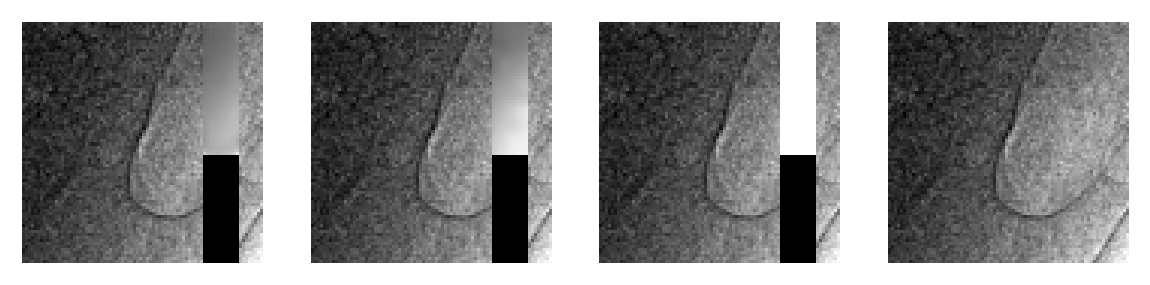

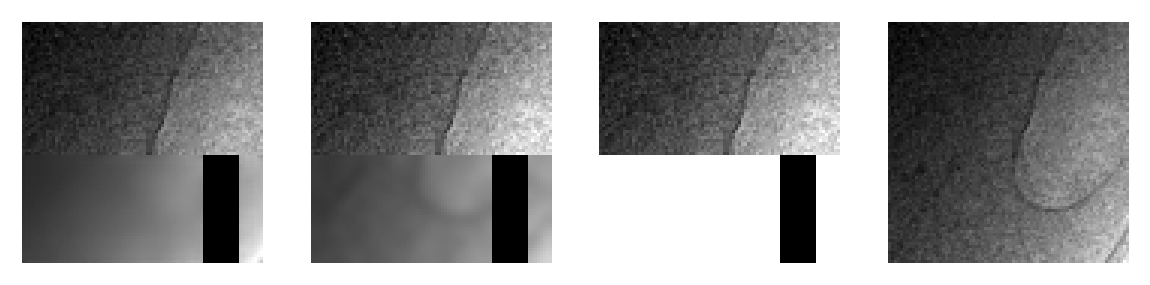

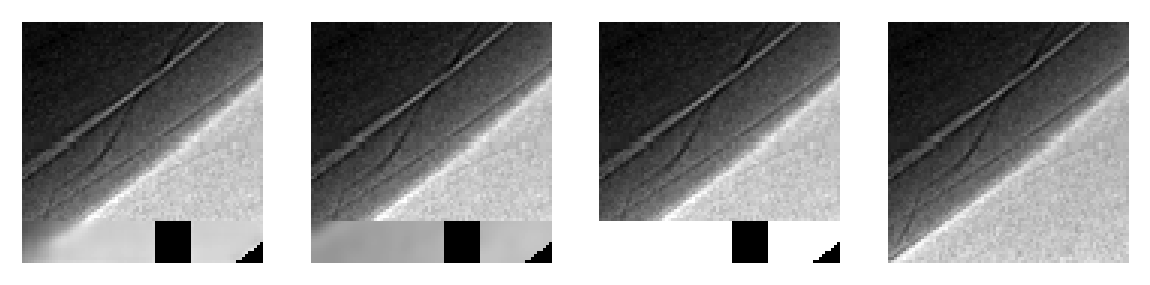

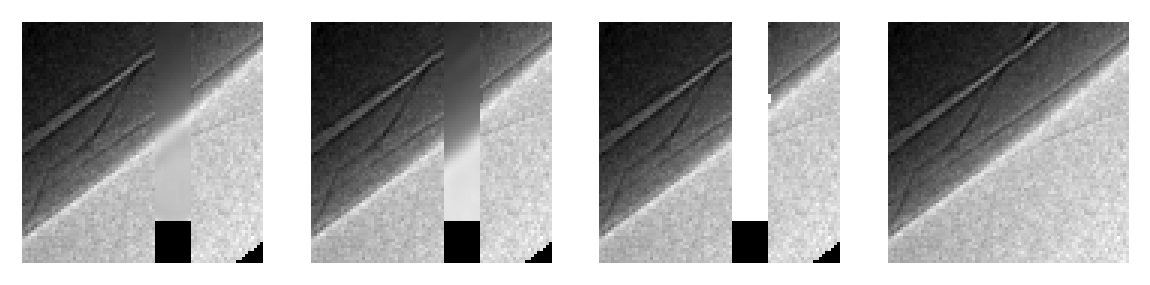

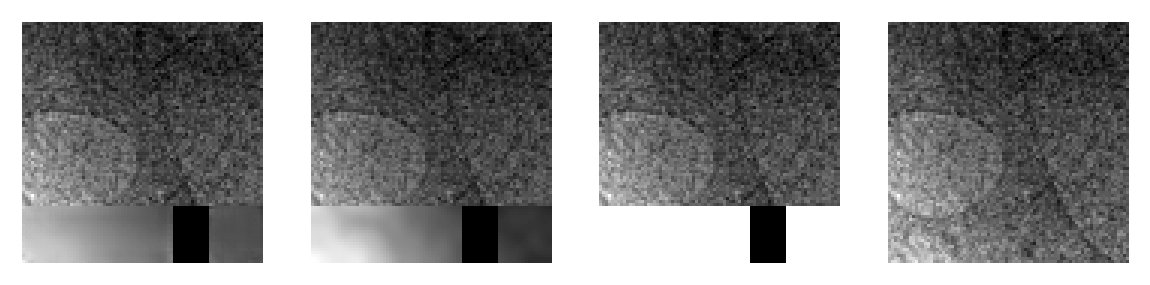

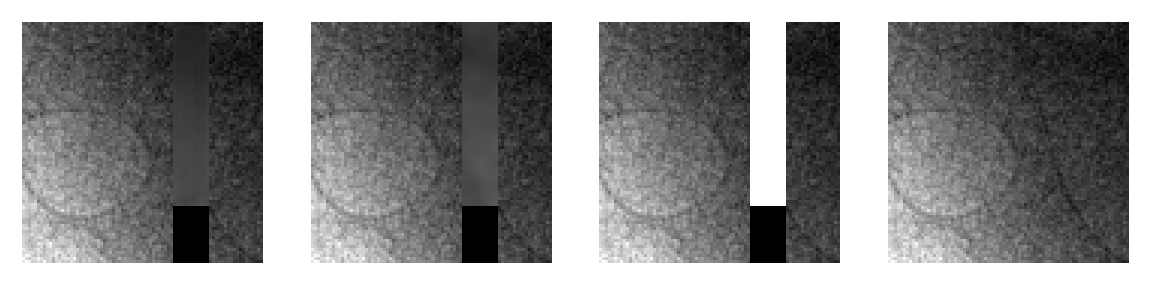

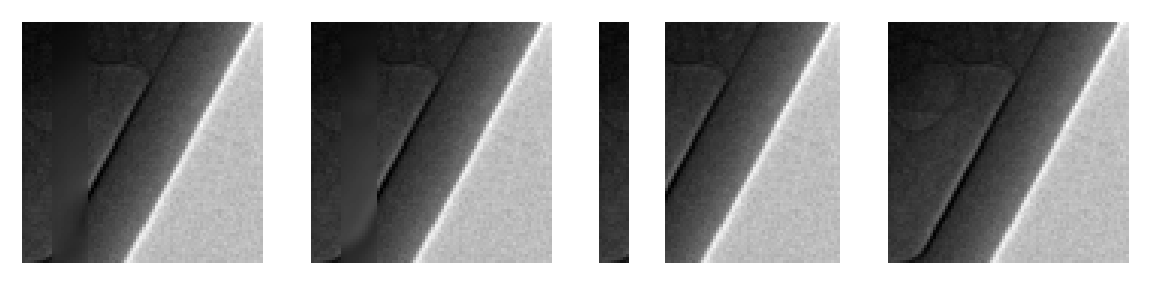

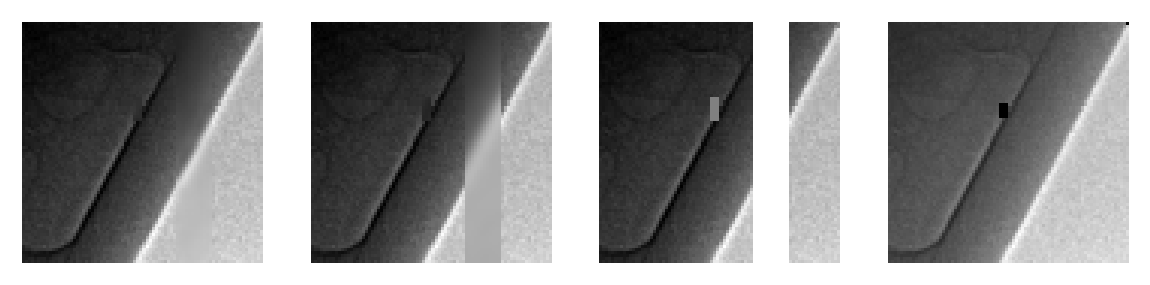

In [10]:

_ = sg.testMe(sg.refImages)


In [ ]:
def fun1() :
    aa = "FINDME"
    fun2()

fun2 = lambda : print(locals)

fun1()

{}


## <font style="color:lightblue">Execute</font>

Epoch:  17 ( 16). L1L: 0.649  MSE: 0.395  Rec: 0.395  (Train: 0.394/0.394, Test: 0.249/0.249).
Image [1, 7015, 493, 842]. L1L: 0.241  MSE: 0.028  Rec: 0.028 
Reference images. L1L: 0.460  MSE: 0.176  Rec: 0.176 


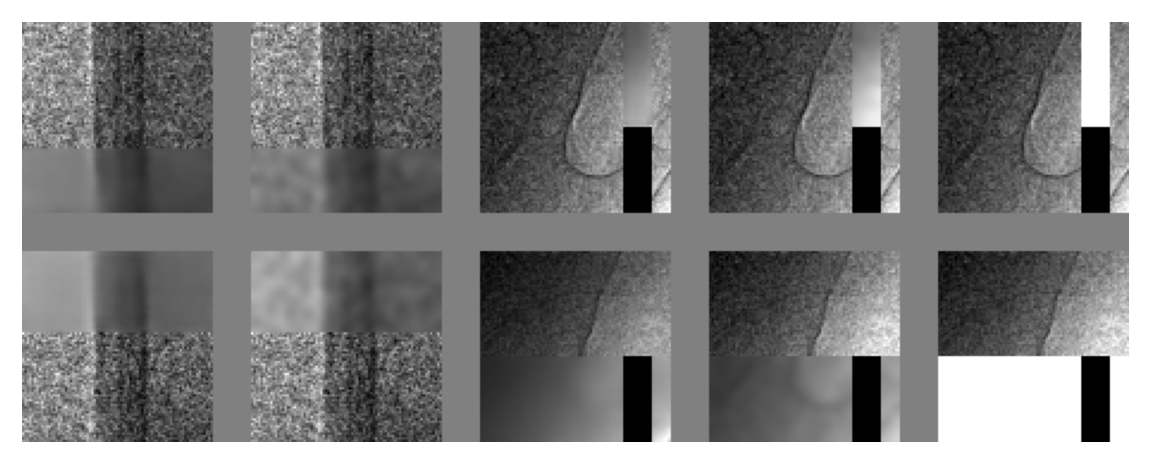

100%|██████████| 5803/5803 [2:11:37<00:00,  1.36s/it]


Losses: Rec 0.0014967163983721243, MSE 0.0014967163983721243, L1L 0.02297449984538326. Pixels: 8634.0.


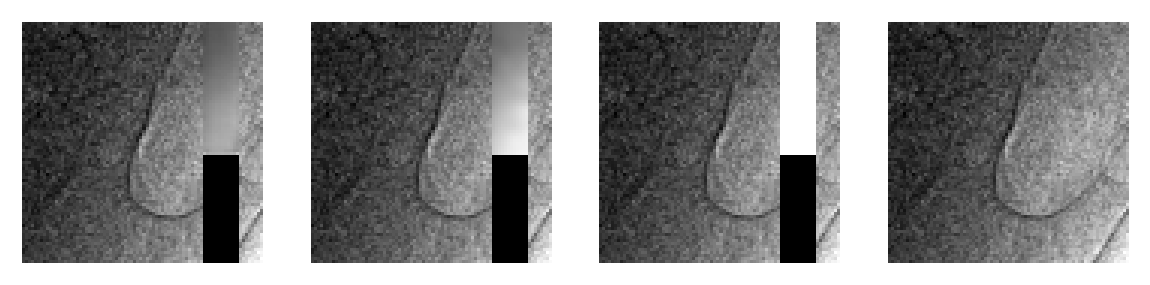

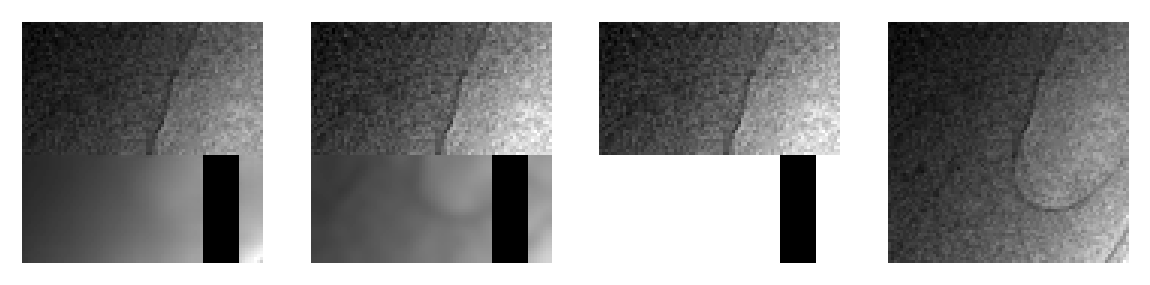

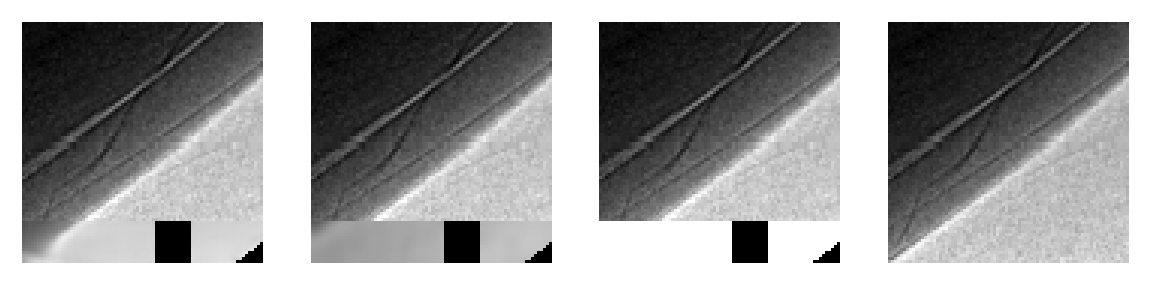

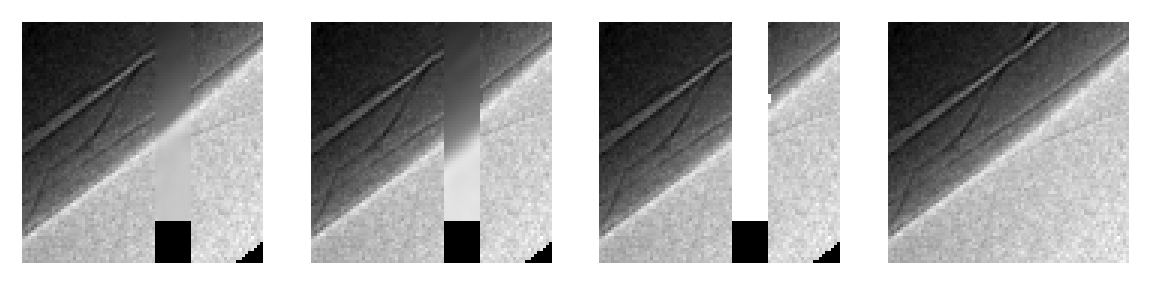

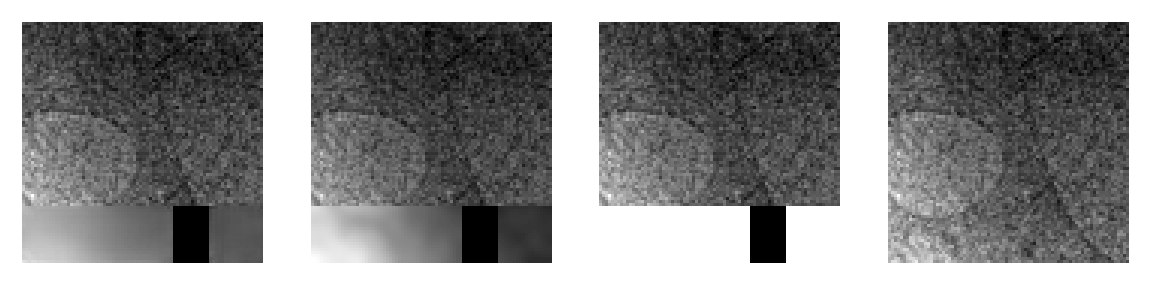

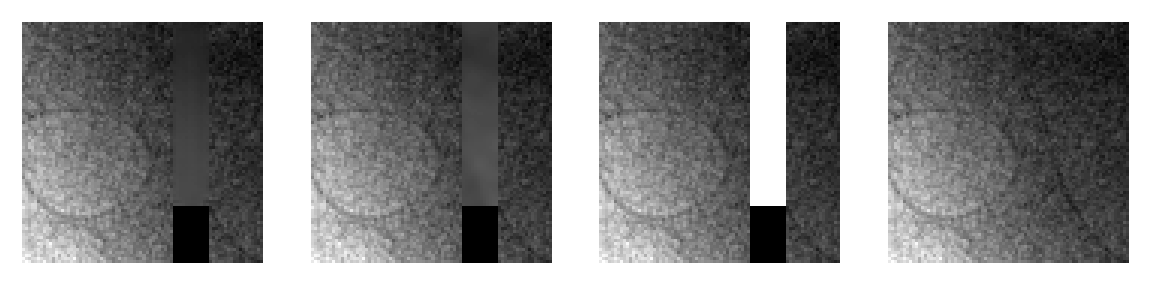

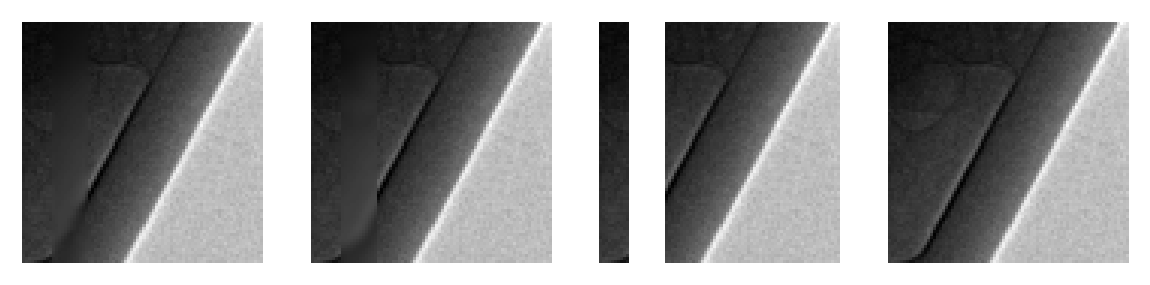

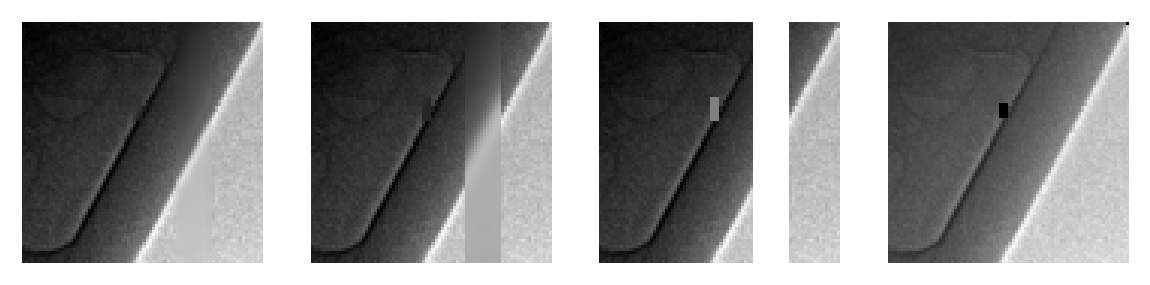

100%|██████████| 574/574 [05:07<00:00,  1.87it/s]


Summary. Rec: 6.318e-04, MSE: 6.318e-04, L1L: 1.204e-02, Dis: 0.000e+00, Gen: 0.000e+00.


  0%|          | 0/5803 [00:00<?, ?it/s]

In [ ]:
#torch.autograd.set_detect_anomaly(True)
sg.noAdv = True

#sg.normRec, sg.normMSE, sg.normL1L = sg.summarizeSet(
#                                            sg.createDataLoader(
#                                                sg.createSubSet(sg.trainSet),
#                                                num_workers=sg.TCfg.loaderWorkers))[0:3]
#sg.normTestRec, sg.normTestMSE, sg.normTestL1L = sg.summarizeSet(sg.testLoader)[0:3]

# These are the norms coming from pre-NN processed data (from Gaussian blur-ed other sibling)
#sg.normRec, sg.normMSE, sg.normL1L =  5.242e-03, 5.242e-03, 3.906e-02 # 3/2
#sg.normTestRec, sg.normTestMSE, sg.normTestL1L = 2.109e-03, 2.109e-03, 1.960e-02 # 5/4
# These are the norms coming from old stich-from-shift approach (before jitter correction).
sg.normRec, sg.normMSE, sg.normL1L =  7.840e-03, 7.840e-03, 4.894e-02 # 2/3
sg.normTestRec, sg.normTestMSE, sg.normTestL1L = 2.575e-03, 2.575e-03, 2.210e-02 # 4/5

#def my_afterEachEpoch(epoch) :
#    if sg.minGEpoch < 600 :
#        return
#    if not sg.dataLoader is None :
#        del sg.dataLoader
#        sg.freeGPUmem()
#    if sg.TCfg.batchSize < 131072 :
#    sg.TCfg.batchSize += round( 0.01 * sg.TCfg.batchSize )
#    sg.dataLoader = sg.createTrainLoader(trainSet, num_workers=24)
#    print("Batch size: ",sg.TCfg.batchSize)
#sg.afterEachEpoch = my_afterEachEpoch

#sg.scheduler_G = torch.optim.lr_scheduler.StepLR(sg.optimizer_G, 1, gamma=1-0.001)
#sg.scheduler_D = torch.optim.lr_scheduler.StepLR(sg.optimizer_D, 1, gamma=1-0.001)
#def my_beforeReport() :
#    lastLR = sg.scheduler_G.get_last_lr()[0]
#    print(f"LR : {lastLR} {lastLR/sg.TCfg.learningRateG:.3f}")
#    if lastLR  <  0.01 * sg.TCfg.learningRateG :
#        return
#    if sg.scheduler_G is not None :
#        sg.scheduler_G.step()
#    if sg.scheduler_D is not None :
#        sg.scheduler_D.step()
#    return
#sg.beforeReport = my_beforeReport

sg.lossAdvCoef = 1.0
sg.lossDifCoef = 1.0

#def my_beforeReport() :
#    #print(sg.normRec, sg.normMSE, sg.normL1L)
#    #print(sg.normTestRec, sg.normTestMSE, sg.normTestL1L)
#    return
#sg.beforeReport = my_beforeReport

try :
    sg.train(savedCheckPoint)
except :
    #del sg.dataLoader
    #del sg.testLoader
    sg.freeGPUmem()
    1/10 # to release Jupyuter memory in the next step
    sg.epoch -= 1
    raise



## <font style="color:lightblue">Post</font>

In [ ]:
print (sg.generator.amplitude.item(), 2 * torch.sigmoid(sg.generator.amplitude).item() )
sg.initialTest()


In [ ]:
sg.testMe(trainSet, 5)

### <font style="color:lightblue">Save results</font>

In [ ]:
sg.saveModels()